# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


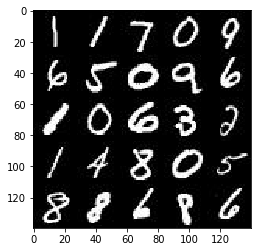

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

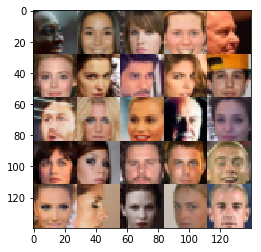

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(None), name="learning_rate")
    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.11
    with tf.variable_scope('discriminator', reuse=reuse):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.4)
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        lr = tf.maximum(alpha * h1, h1)
        drop = tf.nn.dropout(lr, 0.5)
        # ?x14x14x64
        
        h2 = tf.layers.conv2d(drop, 256, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        bn1 = tf.layers.batch_normalization(h2, training=True)
        lr2 = tf.maximum(alpha * bn1, bn1)
        drop2 = tf.nn.dropout(lr2, 0.25)
        # ?x7x7x128
        
        h3 = tf.layers.conv2d(drop2, 512, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        bn2 = tf.layers.batch_normalization(h3, training=True)
        lr3 = tf.maximum(alpha * bn2, bn2)
        # ?x4x4x256
        
        h4 = tf.layers.conv2d(lr3, 1024, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        bn3 = tf.layers.batch_normalization(h4, training=True)
        lr4 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(lr4, 0.7)
        # ?x2x2x512
        
        flatten = tf.reshape(drop3, (-1, 2*2*1024))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.09
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.4)
        h1 = tf.layers.dense(z, 7*7*1024)
        h1_n = tf.nn.l2_normalize(h1, dim=-1, epsilon=1e-12)
        h1_r = tf.reshape(h1_n, (-1, 7, 7, 1024))
        bn1 = tf.layers.batch_normalization(h1_r, training=is_train)
        lr1 = tf.maximum(alpha * bn1, bn1)
        # ?x7x7x1024
        
        h2 = tf.layers.conv2d_transpose(lr1, 512, 5, strides=2, padding='same', kernel_regularizer=regularizer )
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lr2 = tf.maximum(alpha * bn2, bn2)
        #drop = tf.nn.dropout(lr2, 0.5)
        # ?x14x14x256
        
        h3 = tf.layers.conv2d_transpose(lr2, 256, 5, strides=1, padding='same', kernel_regularizer=regularizer)
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lr3 = tf.maximum(alpha * bn3, bn3)
        drop2 = tf.nn.dropout(lr3, 0.5)
        # ?x14x14x128        
        
        
        h4 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=1, padding='same', kernel_regularizer=regularizer)
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lr4 = tf.maximum(alpha * bn4, bn4)
        #drop = tf.nn.dropout(lr4, 0.6)
        # ?x14x14x128
        
        logits = tf.layers.conv2d_transpose(lr4, out_channel_dim, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        #drop3 = tf.nn.dropout(logits, 0.6)
        # ?x28x28x64
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width, img_height, img_channels = data_shape[1], data_shape[2], data_shape[3]
    inputs_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 50
    show_every =  100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.normal(-1, 1, size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 1.1586


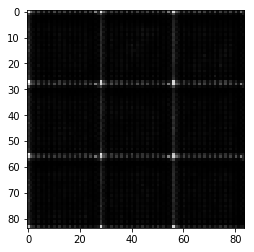

Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 1.1645


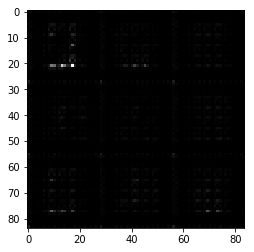

Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.8242


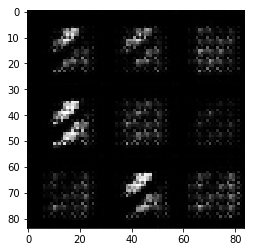

Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.5278... Generator Loss: 0.9008


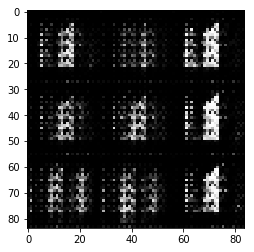

Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 1.0867


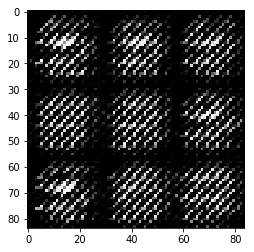

Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.6637... Generator Loss: 0.7316


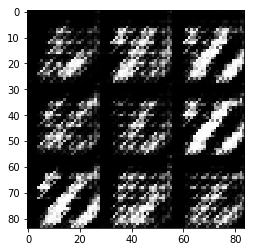

Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.7118


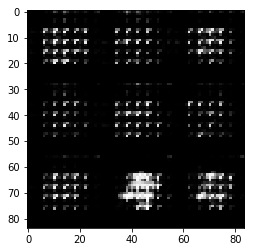

Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.7261


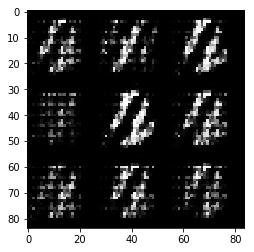

Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.9435


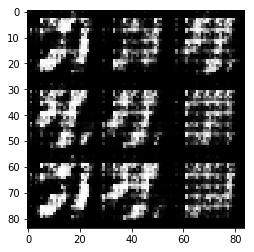

Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.9956


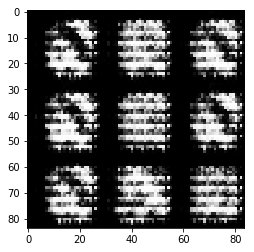

Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 1.1864


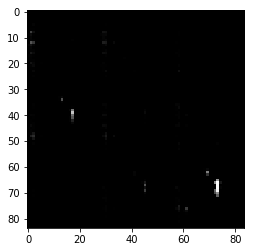

Epoch 1/2... Discriminator Loss: 1.6284... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.8664


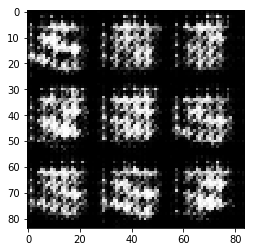

Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 1.2523
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.0283


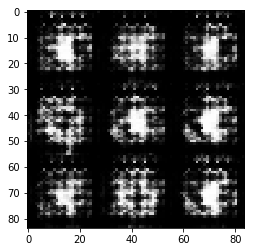

Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.4174
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.0449


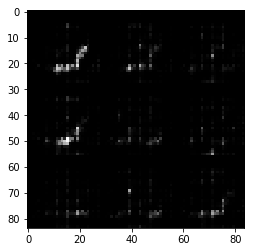

Epoch 1/2... Discriminator Loss: 0.6253... Generator Loss: 2.0651
Epoch 1/2... Discriminator Loss: 1.7005... Generator Loss: 0.5662


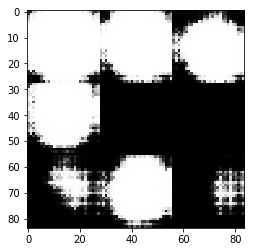

Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 1.0753
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 1.1136


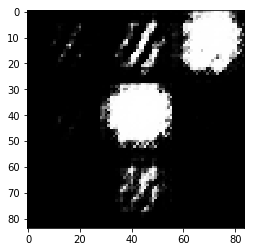

Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.0221


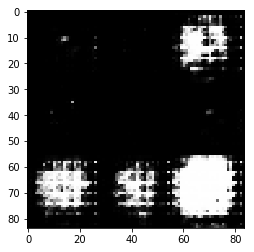

Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.2224


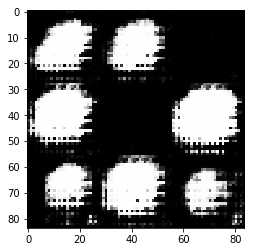

Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 1.0205


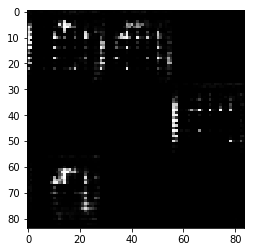

Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 1.0803


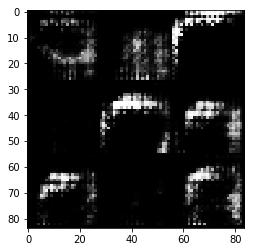

Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 1.1423
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 1.0764


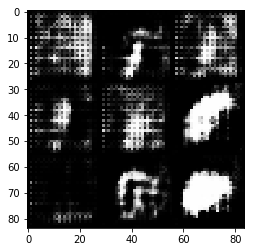

Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 1.0923


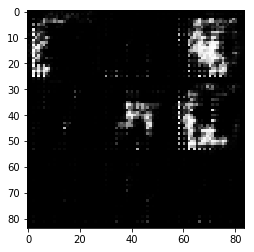

Epoch 2/2... Discriminator Loss: 1.4143... Generator Loss: 1.3573
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.9367


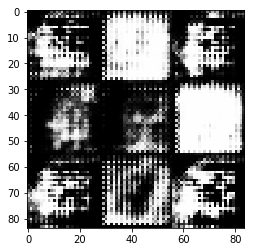

Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.9634


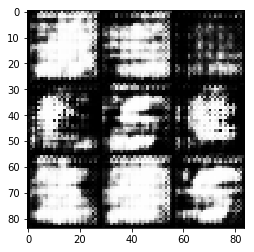

Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.8092


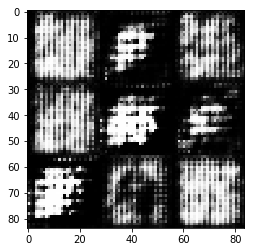

Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.8068


In [ ]:
batch_size = 32 #best at 32 so far - tested: 50 32(-)
z_dim = 400 #best at 100 so far - tested 150(F) 200(?) 400(?)
learning_rate = 0.002
beta1 = 0.3

#top hp's
#batch_size = 50 #best at 150 so far - tested: 50 32(?)
#z_dim = 100 #best at 100 so far - tested 150(F) 250(?)
#learning_rate = 0.002 #best at 0.002 - tested: 0.0002(?)
#beta1 = 0.4 #best at 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA

Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4225... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 2.3091... Generator Loss: 0.7059


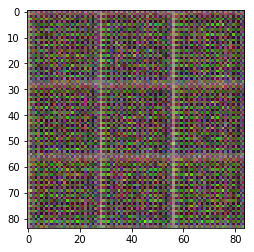

Epoch 1/1... Discriminator Loss: 1.8779... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.8874


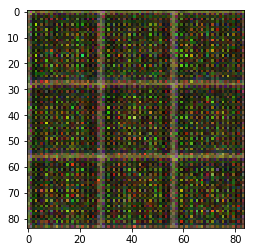

Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.9431... Generator Loss: 0.8285


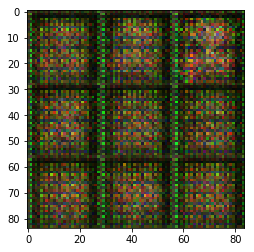

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.8358... Generator Loss: 0.9814


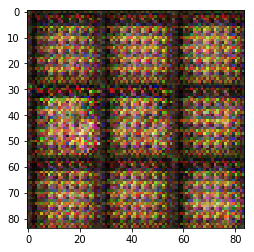

Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.7020


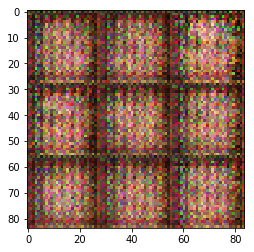

Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 1.1040


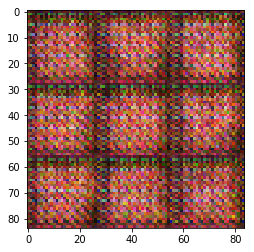

Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.8844


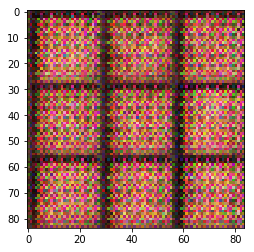

Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.9424


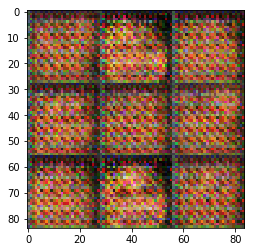

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 1.1917


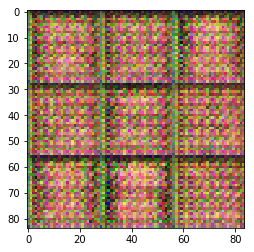

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.8794


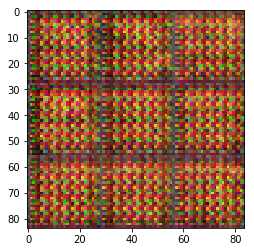

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8120


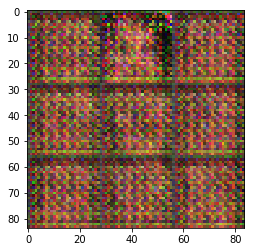

Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.9843


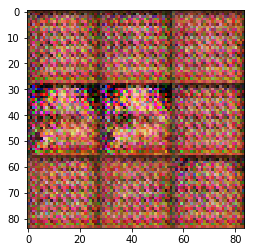

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.9505


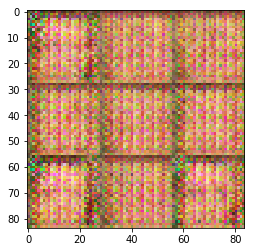

Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.9404


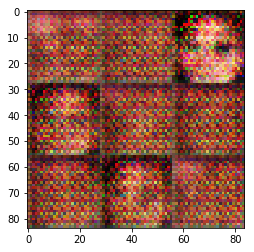

Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.9879


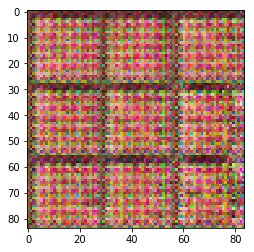

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.7395


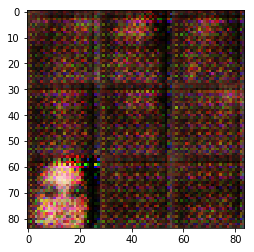

Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.9364


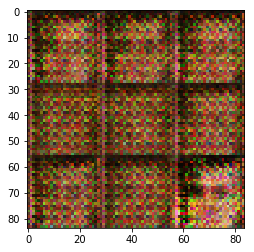

Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.9957


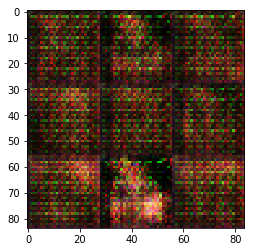

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.9551


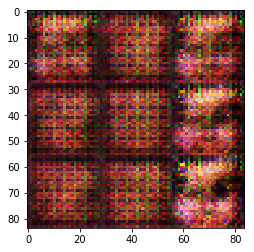

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8459


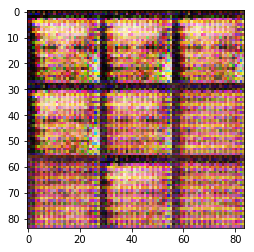

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.7877


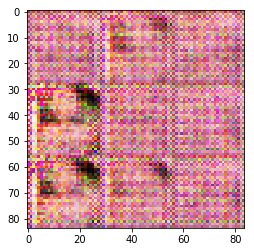

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.9313


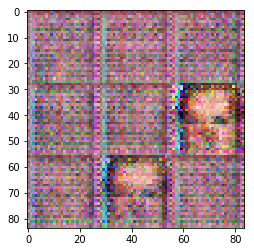

Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.1068


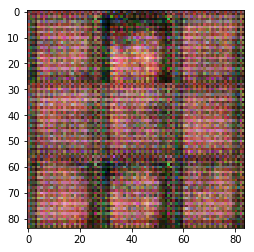

Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8399


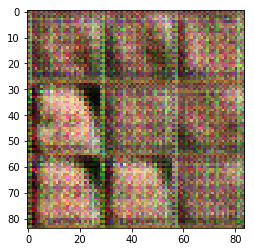

Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7494


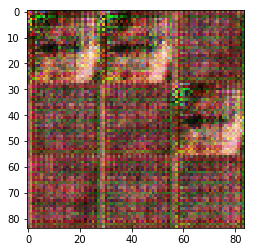

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.2968


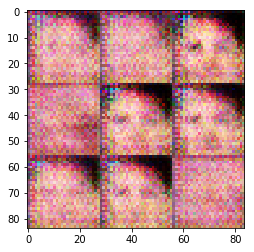

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0750


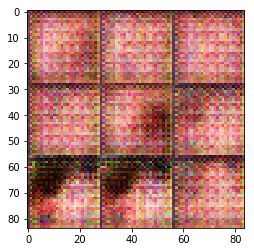

Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 1.1409


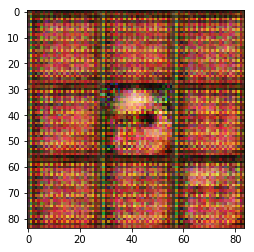

Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.3248


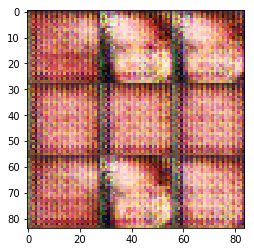

Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9614


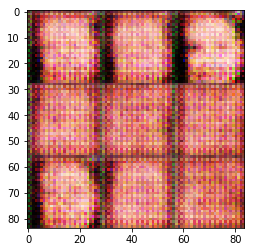

Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 1.4340


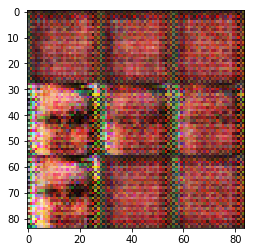

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.2337


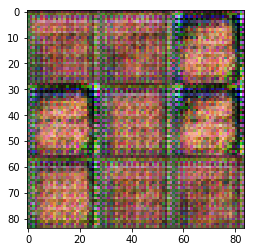

Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.5556


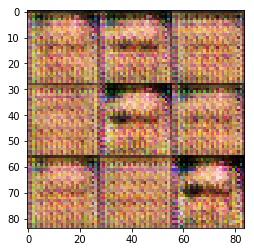

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.4131


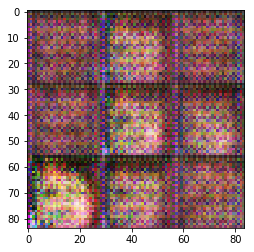

Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.5818


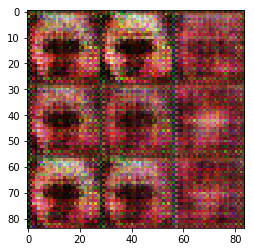

Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.4215


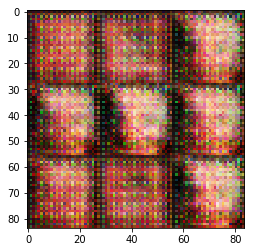

Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.7736
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.6273


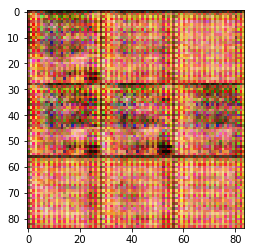

Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.6094


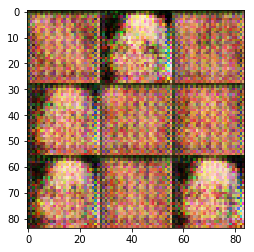

Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 2.0631
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.6589


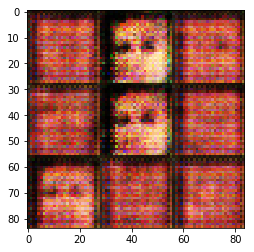

Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 2.0516
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.0958


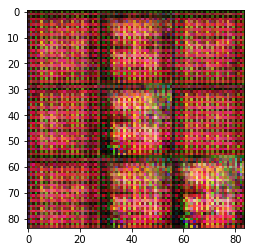

Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.8404


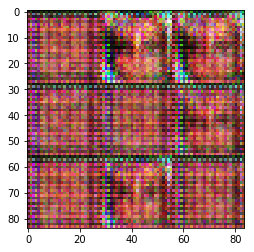

Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.7778
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.9816


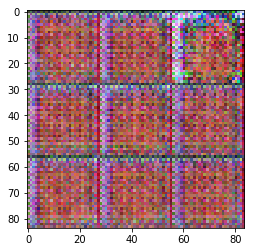

Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.8918


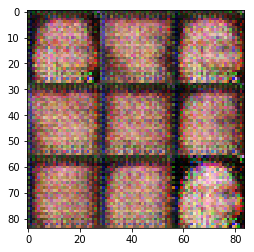

Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.5026


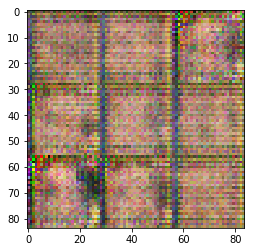

Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9164


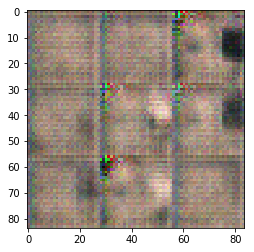

Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.5436
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.3988


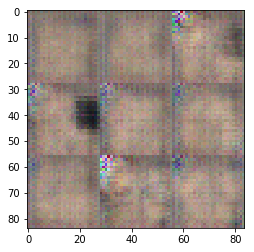

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.3194


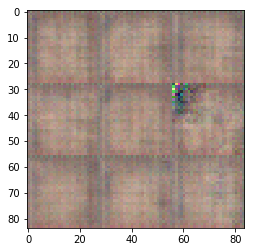

Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.9972


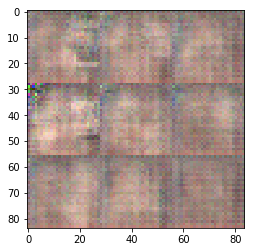

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.0287


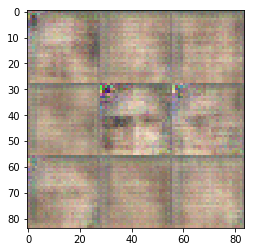

Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.2907


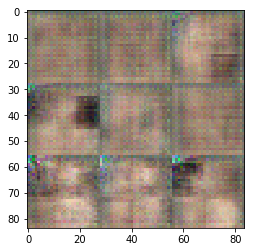

Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.8050


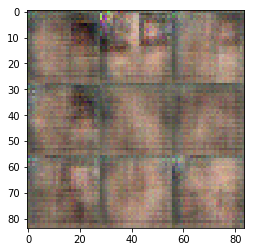

Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0390


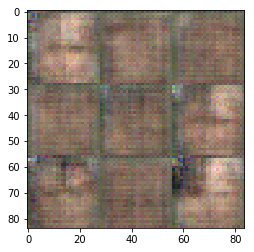

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.9200


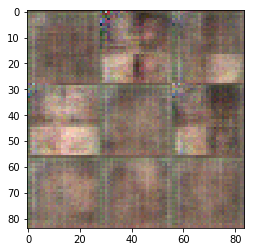

Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 1.6390


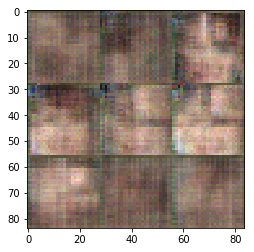

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.5449
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.7808


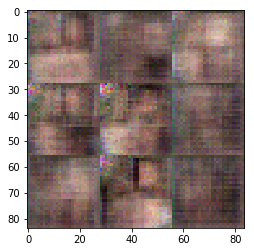

Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0270


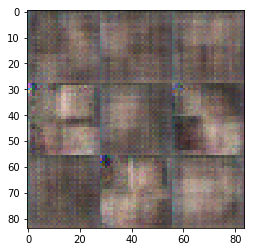

Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.0813


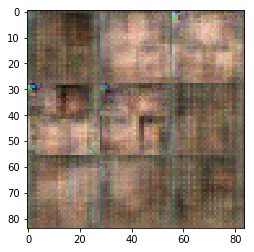

Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8458


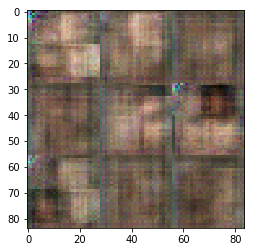

Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.6259
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.4474


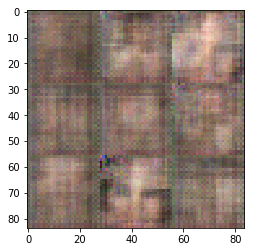

Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.4612


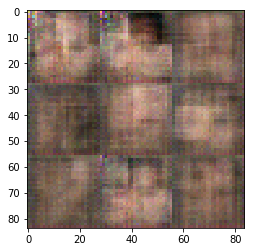

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.8919


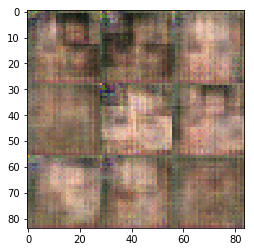

Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.1483


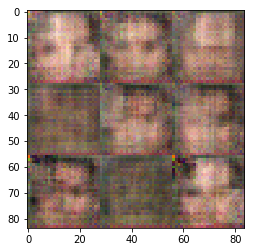

Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.4492


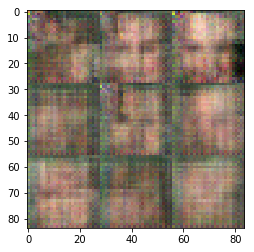

Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 2.0164... Generator Loss: 1.1279


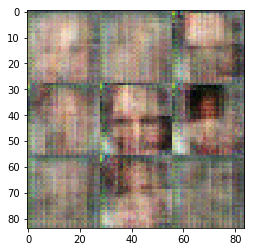

Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8708


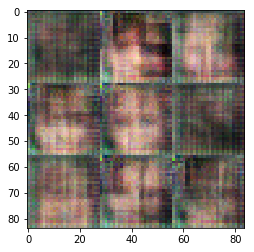

Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.5659


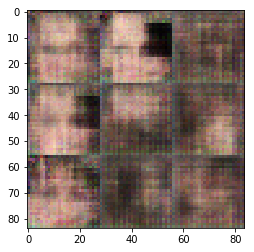

Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.2909


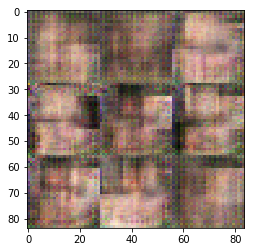

Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.3891


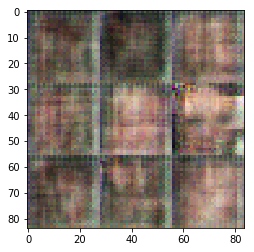

Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.6862


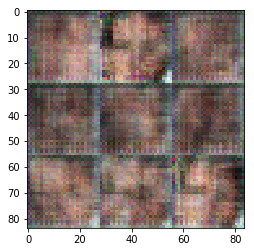

Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.0015


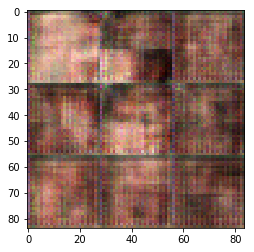

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.1813


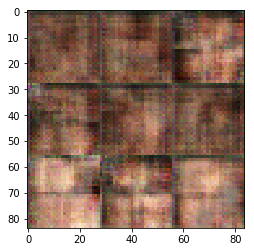

Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.9376


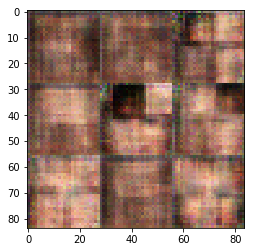

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.6159
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.3504


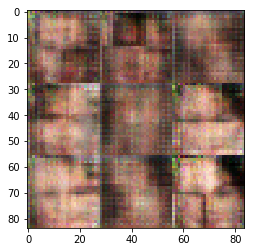

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.7498
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 0.7228


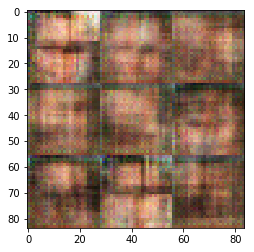

Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.5404


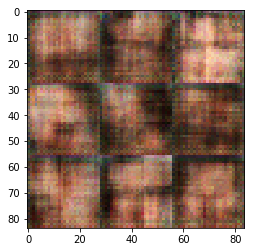

Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.1155


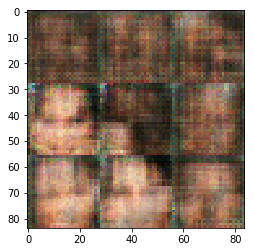

Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.8366


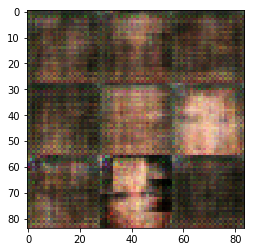

Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.4454


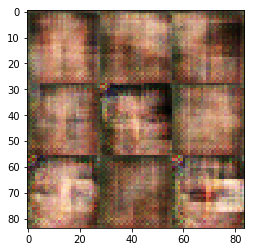

Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.9061


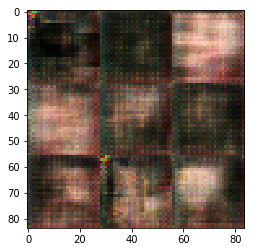

Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 2.3484... Generator Loss: 0.6064


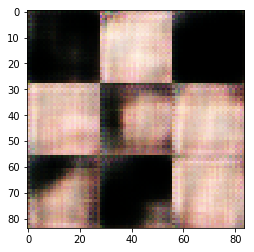

Epoch 1/1... Discriminator Loss: 2.4420... Generator Loss: 0.3615
Epoch 1/1... Discriminator Loss: 2.3371... Generator Loss: 0.3836


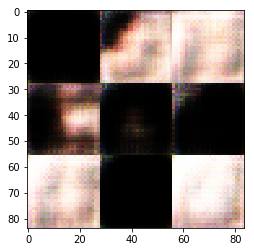

Epoch 1/1... Discriminator Loss: 2.1201... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 2.2145... Generator Loss: 0.5375


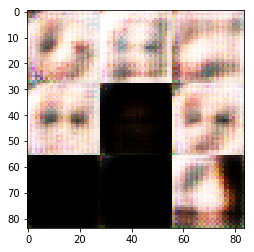

Epoch 1/1... Discriminator Loss: 2.1258... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 0.6879


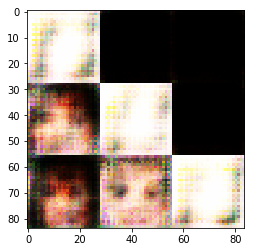

Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.7660... Generator Loss: 0.6017


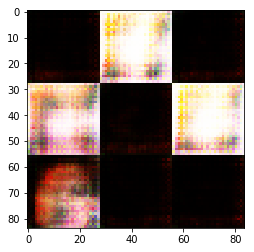

Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.7905


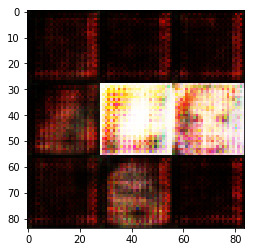

Epoch 1/1... Discriminator Loss: 1.8317... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.7158


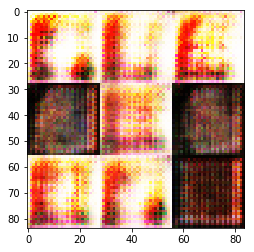

Epoch 1/1... Discriminator Loss: 1.6493... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.8246


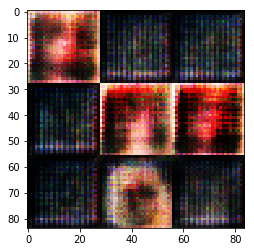

Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 1.0439


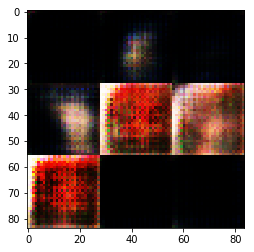

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.5757


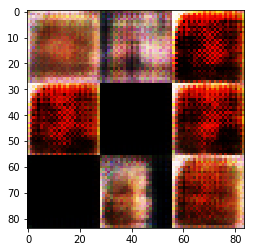

Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.8487


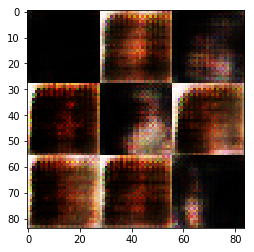

Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6466


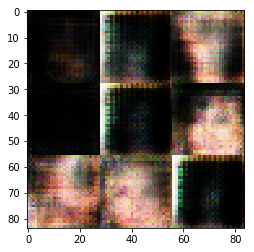

Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.8074


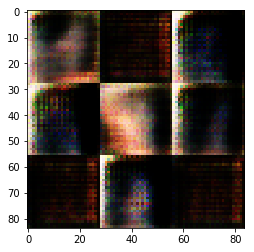

Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.7760


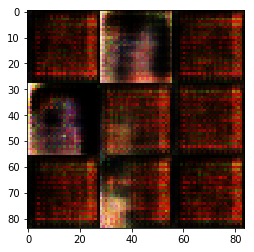

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.7698


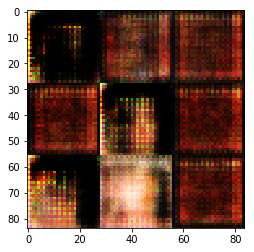

Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7595


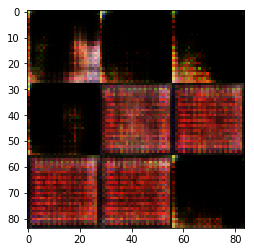

Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.8505


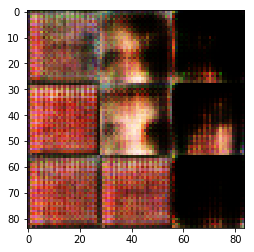

Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.8413


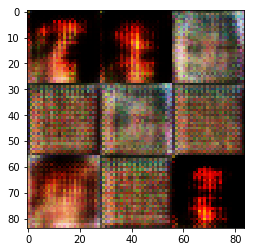

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6771


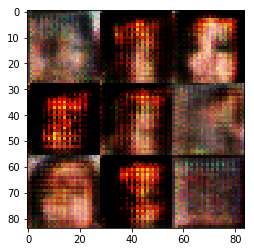

Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.7522


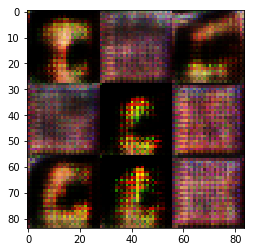

Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.7509


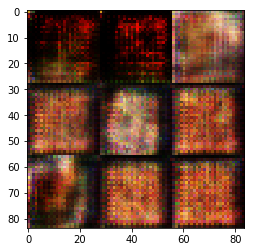

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6873


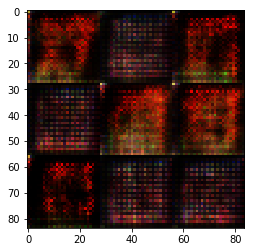

Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 1.0321


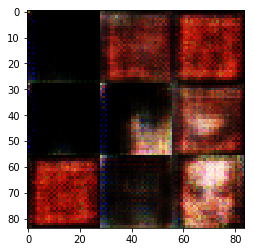

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.9474


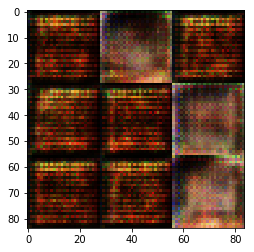

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.8446


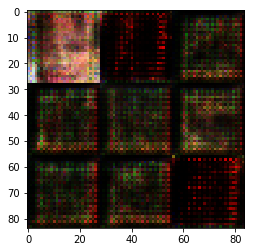

Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 1.0121


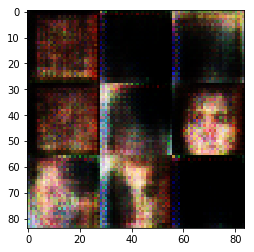

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7399


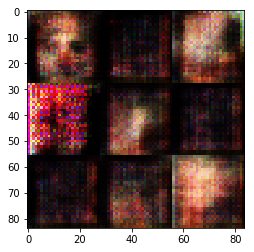

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.9666


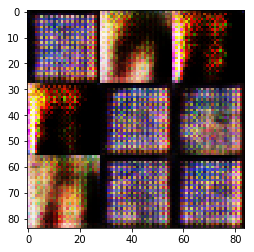

Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7626


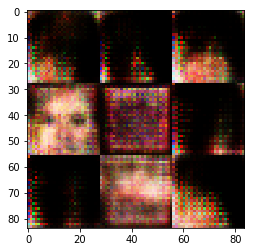

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.8225


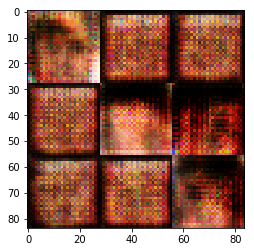

Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.7492


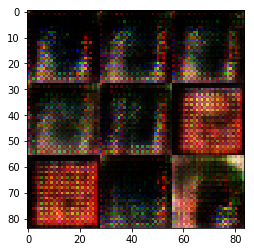

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8247


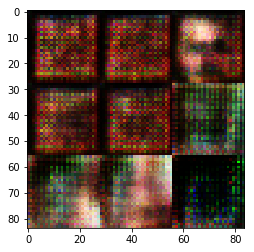

Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7219


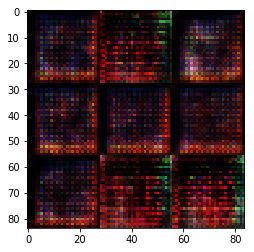

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.8649


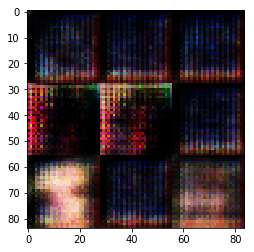

Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.9748


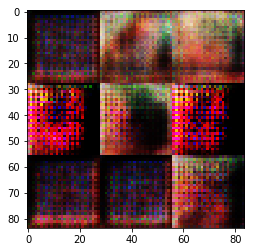

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7018


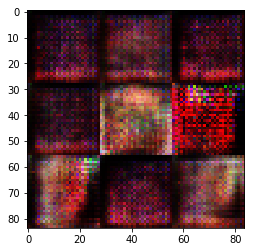

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.9663


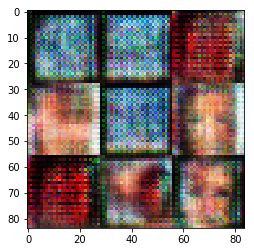

Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.9150


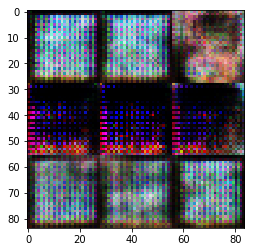

Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7022


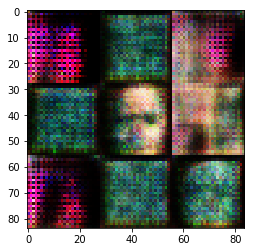

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8078


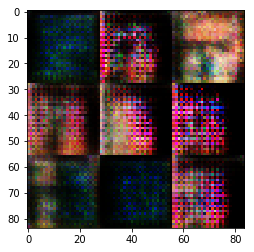

Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.7714


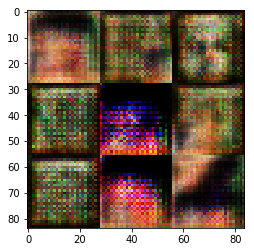

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7914


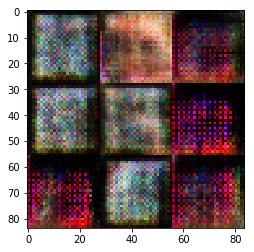

Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.9420


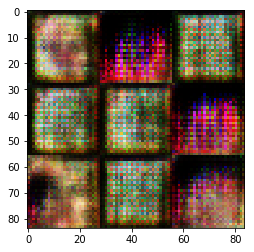

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8722


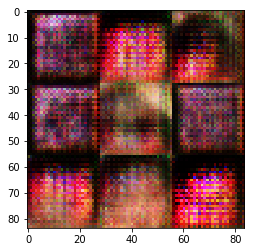

Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7898


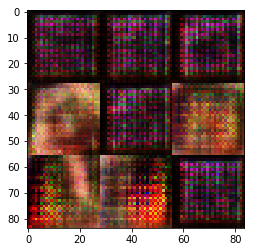

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.8927


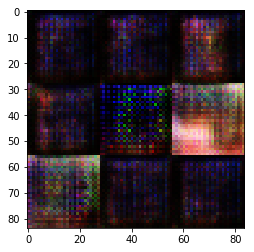

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 1.0544


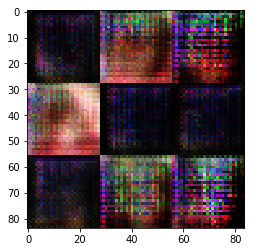

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7986


In [20]:
batch_size = 16
z_dim = 150
learning_rate = 0.0002
beta1 = 0.6

# batch_size = 16 #best at 150 so far - tested: 16(-) 32(-)
# z_dim = 100 #best at 120 so far - tested 120(-) 100(?)
# learning_rate = 0.0003 so far - tested .0003(-) .0005(!)
# beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.